# Subsets for stats in R
In this notebook I'm just selecting out only the columns we need to perform ANOVA and post hoc tests in R. That is, I only need our measurement (normalized intensity) and treatment/reactivation labels. 

In [1]:
import os
import numpy as np
import pandas as pd

In [12]:
for f in os.listdir('NORM'):
    df = pd.read_csv(f'NORM/{f}')

    # split out react and treat cols from combined label
    df['react'] = df.treatment.apply(lambda x: x.split('_')[0])
    df['treat'] = df.treatment.apply(lambda x: x.split('_')[1])

    # rename some cols for convenience
    df = df.rename(columns={'treatment': 'react_treat', 'norm_adjusted_mean-background': 'norm_int'})

    # write to disk
    df[['react_treat', 'react', 'treat', 'norm_int']].to_csv(f.replace('.csv', '_Rsubset.csv'))

In [2]:
import shutil

if os.path.exists('NORM_MEANS') and os.path.isdir('NORM_MEANS'):
    shutil.rmtree('NORM_MEANS')

os.mkdir('NORM_MEANS')
for f in os.listdir('NORM'):
    df = pd.read_csv(f'NORM/{f}')

    df_means = df.groupby('rat_n')['norm_adjusted_mean-background'].mean().reset_index(name='mean_norm_intensity')
    df_merge = df[['rat_n', 'coloc_stain_type']].drop_duplicates().merge(df_means)
    df_merge['n0'], df_merge['n1'] = zip(*df_merge.rat_n.apply(lambda x: [int(y) for y in x.split('-')[1:]]))
    df_merge = df_merge.merge(df_merge.merge(df[['rat_n', 'treatment']].drop_duplicates()))
    df_merge = df_merge.sort_values(by=['treatment', 'n0', 'n1'])[['rat_n', 'treatment', 'coloc_stain_type', 'mean_norm_intensity']]

    f_means = f.replace('.csv', '_MEANS_BY_RAT.csv')

    df_merge.to_csv(f'NORM_MEANS/{f_means}')



In [3]:
df_merge

,rat_n,treatment,coloc_stain_type,mean_norm_intensity
9,KET-9-1,FR1_KET,"WFA_coloc_w_cFos,Npas4",1.274493
0,KET-10-12,FR1_KET,"WFA_coloc_w_cFos,Npas4",0.577682
14,PE-12-1,FR1_KET,"WFA_coloc_w_cFos,Npas4",0.353281
15,PE-12-2,FR1_KET,"WFA_coloc_w_cFos,Npas4",0.690518
16,PE-12-7,FR1_KET,"WFA_coloc_w_cFos,Npas4",0.682492
7,KET-8-2,FR1_SAL,"WFA_coloc_w_cFos,Npas4",0.398936
10,KET-9-2,FR1_SAL,"WFA_coloc_w_cFos,Npas4",1.438319
11,KET-9-4,FR1_SAL,"WFA_coloc_w_cFos,Npas4",1.078667
12,KET-9-5,FR1_SAL,"WFA_coloc_w_cFos,Npas4",1.477433
13,KET-9-6,FR1_SAL,"WFA_coloc_w_cFos,Npas4",0.480993


In [31]:
import shutil

def normalize_intensity(df, norm_condition, col='mean-background'):
    '''
    computes the mean of rows of the norm_condition and divides mean-background by this mean,
    normalizing all data to the mean of the norm_condition. sets normalized value into new
    column called "norm mean-background" and returns new dataframe containing normalized intensity.
    '''
    df_norm = df[df.treatment == norm_condition]
    norm_mean = df_norm[col].astype('f').mean()

    df_norm = df.copy(deep=True)
    df_norm[f'norm_{col}'] = df[col].astype('f') / norm_mean

    # quickly check that the mean of the norm condition is set to about 1.00000
    # this is never exatly 1 due to small rounding errors from floating point operations
    assert round(df_norm[df_norm.treatment == norm_condition][f'norm_{col}'].mean(), 5) == 1
    
    return df_norm

if os.path.exists('R_posthoc_subsets') and os.path.isdir('R_posthoc_subsets'):
    shutil.rmtree('R_posthoc_subsets')

os.mkdir('R_posthoc_subsets')

# read in final complete adjusted set (NOT yet normalized)
# we will need to normalize for each stain-type combination we want to investigate post-hoc
df = pd.read_csv('KET-VR5_FINAL.csv')

for stain in df.stain_type.unique():
    df_subset = df.query(f'stain_type == "{stain}"')[['stain_type', 'adjusted_mean-background', 'treatment', 'dummy_PV', 'dummy_cFos', 'dummy_Npas4', 'dummy_WFA']]
    df_norm = normalize_intensity(df_subset.rename(columns={'adjusted_mean-background': 'intensity'}), norm_condition='FR1_SAL', col='intensity')
    df_norm.to_csv(f'R_posthoc_subsets/NORM_single_{stain}.csv')

# to reduce to from 3 way anova to 2 way ANOVA.

<Axes: xlabel='dummy_PV', ylabel='norm_intensity'>

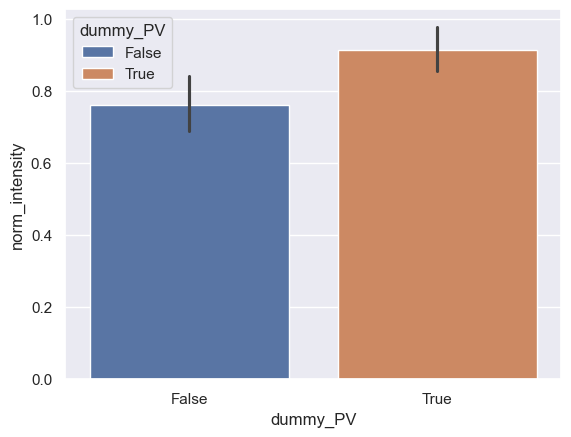

In [32]:
# let's just check that the normalized result comes out as we expect 

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.barplot(y='norm_intensity',  x='dummy_PV', hue='dummy_PV', data=df_norm)